In [18]:
import torch
from torch.utils.data import DataLoader, random_split

# Load the dataset
train_dataset = torch.load('torch_trainset.pt')
test_dataset  = torch.load('torch_testset.pt')

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [19]:
import timm
import torch.nn as nn

# Load a pre-trained EfficientNet model
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the classifier
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  # Assuming binary classification

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [20]:
import torch.optim as optim

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:

best_val_accuracy = 0.0
best_model_path = 'best_model.pth'

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    global best_val_accuracy  # Access the global variable
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

        # Check if this is the best model so far
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy  # Update the best accuracy
            print(f'Saving new best model with accuracy: {accuracy:.2f}%')
            torch.save(model.state_dict(), best_model_path)  # Save model state dictionary

# Execute the training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.2450
Validation Accuracy: 86.76%
Saving new best model with accuracy: 86.76%
Epoch [2/10], Loss: 0.1039
Validation Accuracy: 93.10%
Saving new best model with accuracy: 93.10%
Epoch [3/10], Loss: 0.0720
Validation Accuracy: 96.76%
Saving new best model with accuracy: 96.76%
Epoch [4/10], Loss: 0.0511
Validation Accuracy: 96.99%
Saving new best model with accuracy: 96.99%
Epoch [5/10], Loss: 0.0430
Validation Accuracy: 96.76%
Epoch [6/10], Loss: 0.0367
Validation Accuracy: 96.99%
Epoch [7/10], Loss: 0.0419
Validation Accuracy: 96.62%
Epoch [8/10], Loss: 0.0343
Validation Accuracy: 97.24%
Saving new best model with accuracy: 97.24%
Epoch [9/10], Loss: 0.0357
Validation Accuracy: 96.37%
Epoch [10/10], Loss: 0.0277
Validation Accuracy: 97.13%


In [22]:
def get_predictions(model, data_loader):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(data_loader))  # Get one batch of data

    # Move tensors to the appropriate device
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    return images.cpu(), labels.cpu(), predicted.cpu()

# Load a batch of images and get actual and predicted labels
images, actual_labels, predicted_labels = get_predictions(model, train_loader)

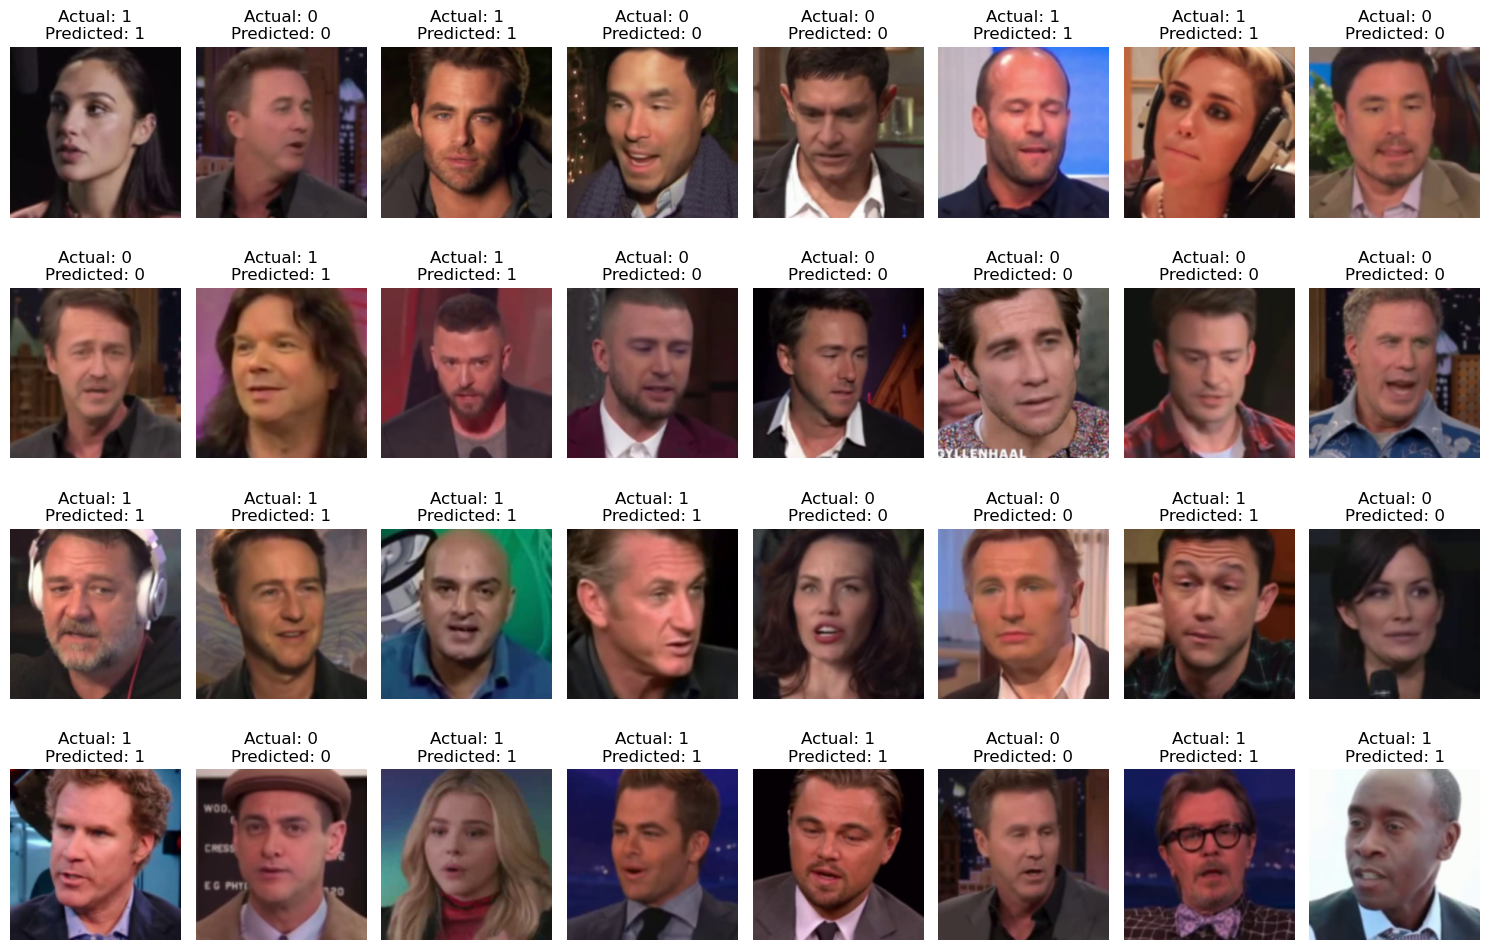

In [23]:
import matplotlib.pyplot as plt
def show_images_with_predictions(images, actual_labels, predicted_labels, num_images=32):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(4, 8, i + 1)
        rgb_img = images[i][[2, 1, 0], :, :]  # Reorder the channels from BGR to R
        ax.imshow(rgb_img.permute(1, 2, 0))  # Adjust the channel dimension Convert from (C, H, W) to (H, W, C)
        plt.title(f'Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the images with labels
show_images_with_predictions(images, actual_labels, predicted_labels)

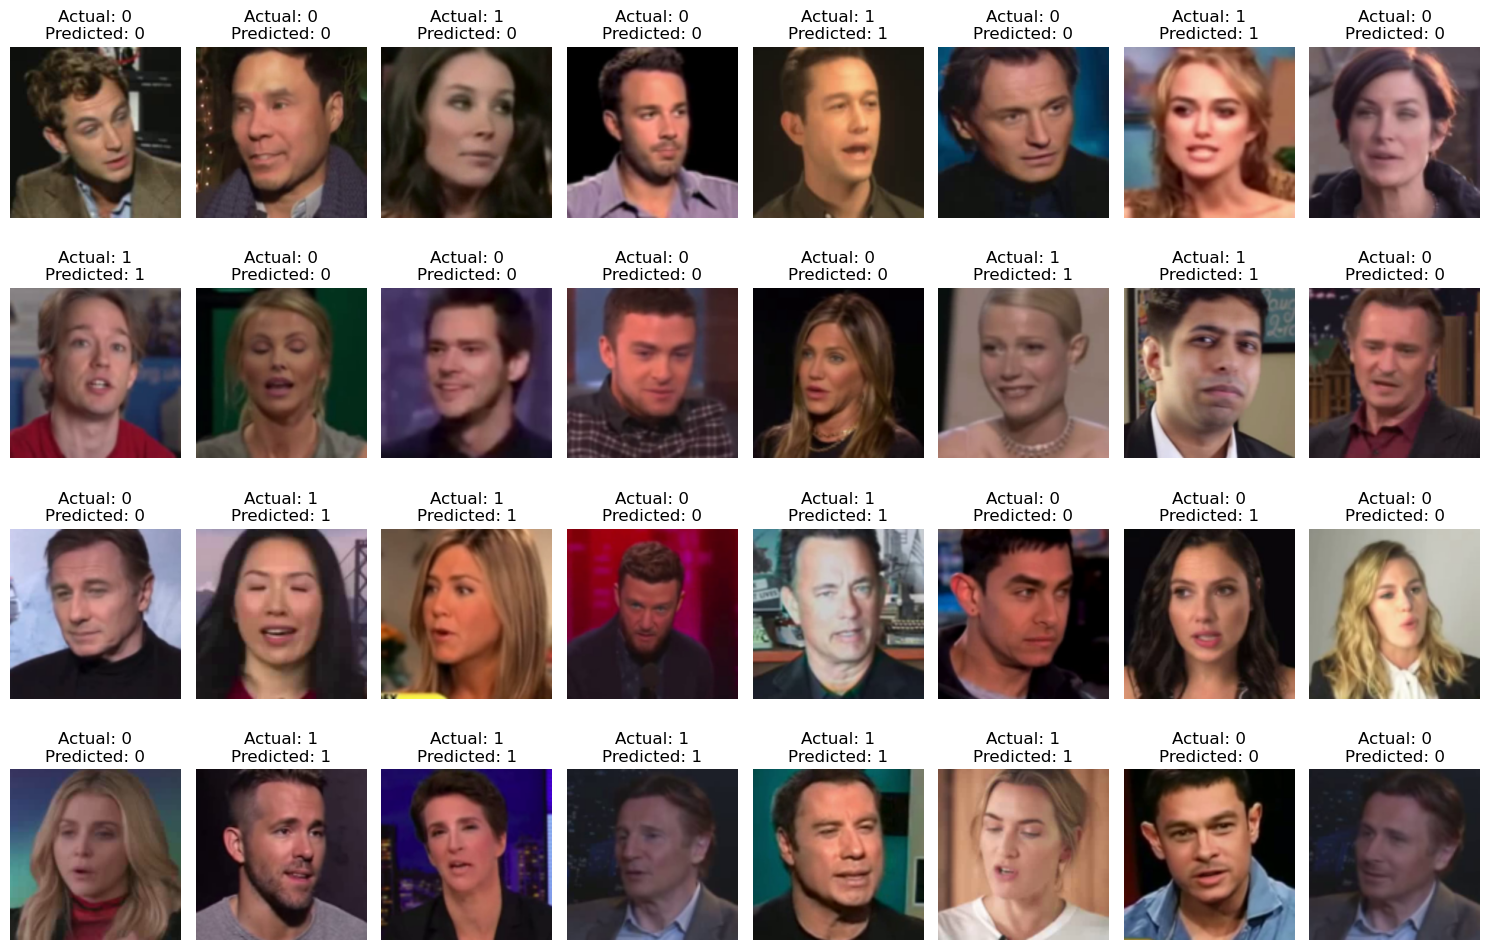

In [24]:
test_images, test_actual_labels, test_predicted_labels = get_predictions(model, test_loader)
show_images_with_predictions(test_images, test_actual_labels, test_predicted_labels)

In [25]:
import torch
from torch.utils.data import DataLoader

model.eval()

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate Accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 95.86%


In [28]:
import matplotlib.pyplot as plt

model.eval()  # Ensure the model is in evaluation mode.

incorrect_samples = []
with torch.no_grad():  # Disabling gradient calculation
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect incorrect samples
        mask = predicted != labels
        for img, pred, true in zip(inputs[mask], predicted[mask], labels[mask]):
            incorrect_samples.append((img.cpu(), pred.item(), true.item()))

print(len(incorrect_samples))

215


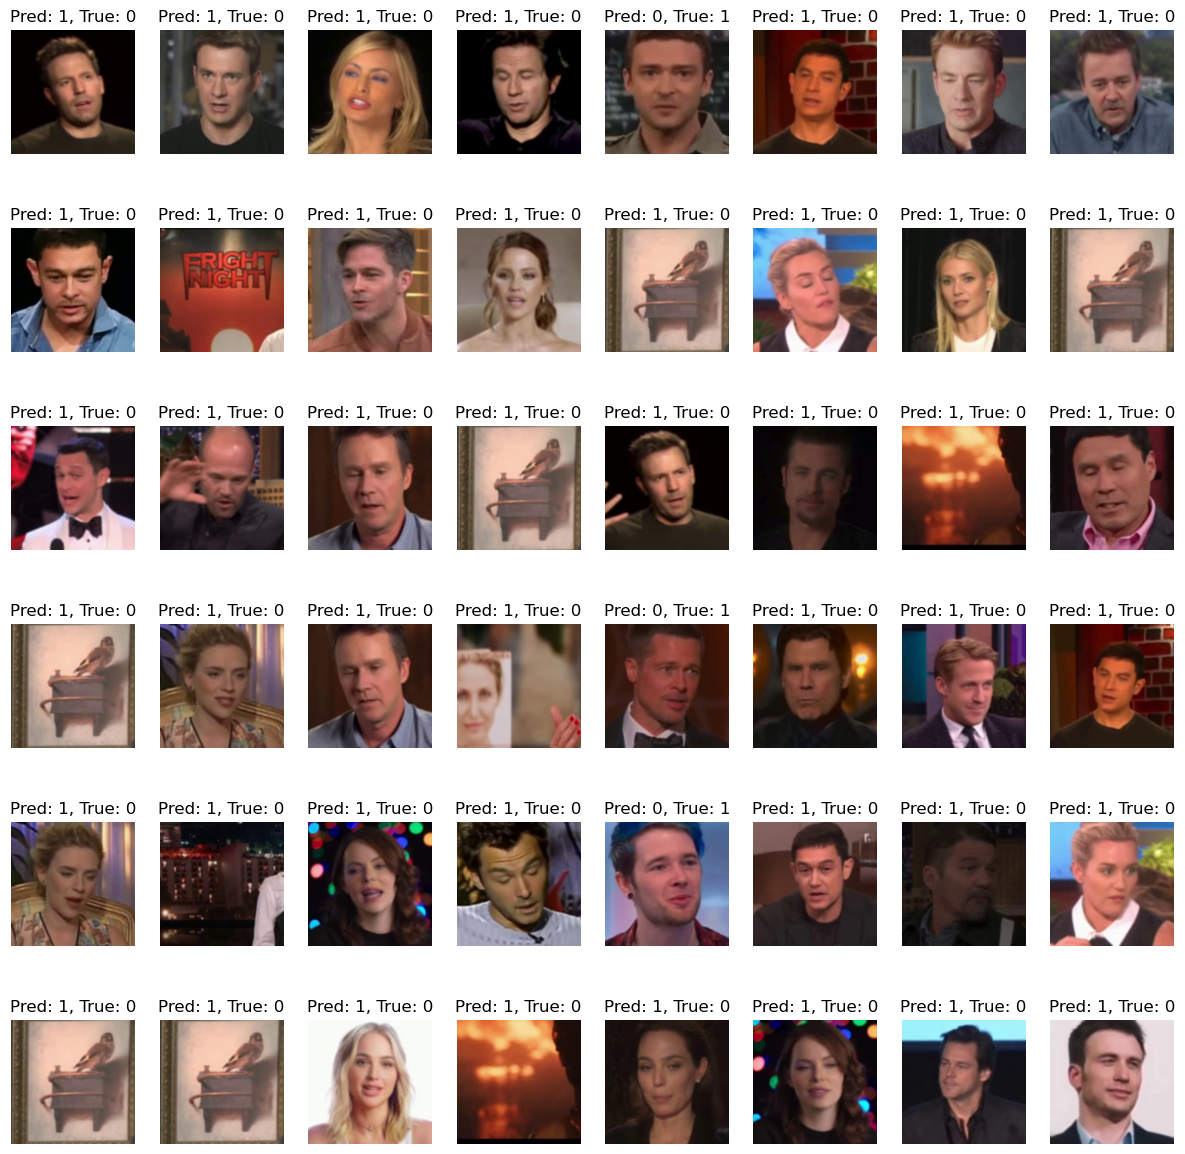

In [32]:
import numpy as np

def imshow(img):
    # Unnormalize if necessary (depending on your data normalization)
    img = img   # If you normalized your images to [-1, 1] range during preprocessing.
    npimg = img.numpy()
    npimg = npimg[[2, 1, 0], :, :]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Display the first few incorrectly classified samples
figure = plt.figure(figsize=(15, 15))
cols, rows = 8, 6
for i, (img, pred, true) in enumerate(incorrect_samples[:rows*cols]):
    figure.add_subplot(rows, cols, i+1)
    title = f'Pred: {pred}, True: {true}'
    plt.title(title)
    imshow(img.squeeze())  # Assuming img is a torch tensor and has an extra batch dimension
plt.show()
